In [29]:
from neo4j import GraphDatabase
import pandas as pd
from py2neo import Graph, Node, Relationship
import json
import os
import csv
import collections
import re
from jsonpath_ng.ext import parse
import ssl
import networkx as nx
import concurrent.futures
import time
import matplotlib.pyplot as plt
import collections

In [121]:
from gqlalchemy import Memgraph
memgraph = Memgraph("localhost", 7687)

In [122]:
graph = Graph("http://localhost:7474")

In [10]:
directory_path = "ali_nicholas_EuSNbSe2_gemd_model_dumps"
json_data = []
for filename in os.listdir(directory_path):
    file_path = os.path.join(directory_path, filename)
    try:
        with open(file_path, encoding='utf-8') as file:
            json_data.append(json.load(file))
    except:
        print("skipping")

skipping
skipping
skipping
skipping
skipping


# Graph Traits #

In [13]:
def create_pairs():
    ingredient_spec_expr = parse('$[?(@.type == "ingredient_spec")]')
    nodes = ingredient_spec_expr.find(json_data)
    materialSpec_to_ingredientSpec = collections.defaultdict(list)
    for n in nodes:
        ingredient_id = n.value['uids']['auto']
        material_id = n.value['material']['id']
        materialSpec_to_ingredientSpec[material_id].append(ingredient_id)
    ingredient_spec_expr = parse('$[?(@.type == "ingredient_spec")]')
    nodes = ingredient_spec_expr.find(json_data)
    processSpec_to_ingredientSpec = collections.defaultdict(list)
    for n in nodes:
        ingredient_id = n.value['uids']['auto']
        process_id = n.value['process']['id']
        processSpec_to_ingredientSpec[process_id].append(ingredient_id)
    ingredient_run_expr = parse('$[?(@.type == "ingredient_run")]')
    nodes = ingredient_run_expr.find(json_data)
    processRun_to_ingredientRun = collections.defaultdict(list)
    for n in nodes:
        ingredient_id = n.value['uids']['auto']
        process_id = n.value['process']['id']
        processRun_to_ingredientRun[process_id].append(ingredient_id)
    measurement_run_expr = parse('$[?(@.type == "measurement_run")]')
    nodes = measurement_run_expr.find(json_data)
    materialRun_to_measurementRun = collections.defaultdict(list)
    for n in nodes:
        measurement_id = n.value['uids']['auto']
        material_id = n.value['material']['id']
        materialRun_to_measurementRun[material_id].append(measurement_id)
    return materialSpec_to_ingredientSpec, processSpec_to_ingredientSpec, processRun_to_ingredientRun, \
           materialRun_to_measurementRun

In [14]:
materialSpec_to_ingredientSpec, processSpec_to_ingredientSpec, processRun_to_ingredientRun, \
materialRun_to_measurementRun = create_pairs()

## On original graph ##

Assumptions:
1. spec nodes and its corresponding run nodes will point towards the same parameter_template and condition_template nodes

In [20]:
# 1. Find all triangles in the graph, and count the number of triangles that each edge participates in.
# 2. Repeatedly find a vertex v that is an endpoint of an edge participating in a number of triangles equal 
#    to the degree of v minus one, delete v, and decrement the triangles per edge of each remaining edge that 
#   formed a triangle with v. 
def isCopWin():
    Id_to_cnt = getTriangles()
    removeId = findDominant(Id_to_cnt)
    while removeId:
        print(removeId)
        Id_to_cnt = removeDominant(removeId, Id_to_cnt)
        removeId = findDominant(Id_to_cnt)
    query = """
            MATCH (n)
            RETURN count(distinct n.node_id) as remaining_cnt
            """
    result = graph.run(query)
    for record in result:
        if record['remaining_cnt'] == 1:
            return True
    return False
                
        
    
# find the number of triangles that each edge participated in
def getTriangles():
    Id_to_cnt = {}
    query = """
            MATCH path = (n)-[e1]-(m)-[e2]-(p)-[e3]-(n)
            WHERE ID(e1) < ID(e2) AND ID(e2) < ID(e3) AND ID(e1) < ID(e3)
            RETURN n.node_id as nid, m.node_id as mid, count(path) as pathCount
            """
    result = graph.run(query)
    for record in result:
        nid = record['nid']
        mid = record['mid']
        pathCount = record['pathCount']
        if (nid, mid) in Id_to_cnt:
            print('edge already visited')
        else:
            Id_to_cnt[(nid, mid)] = pathCount
    query = """
            MATCH path = (n)-[e1]-(m)-[e2]-(p)-[e3]-(n)
            WHERE ID(e1) < ID(e2) AND ID(e2) < ID(e3) AND ID(e1) < ID(e3)
            RETURN m.node_id as mid, p.node_id as pid, count(path) as pathCount
            """
    for record in result:
        mid  = record['mid']
        pid = record['pid']
        pathCount = record['pathCount']
        if (mid, pid) in Id_to_cnt:
            print('edge already visited')
        else:
            Id_to_cnt[(mid, pid)] = pathCount
    query = """
            MATCH path = (n)-[e1]-(m)-[e2]-(p)-[e3]-(n)
            WHERE ID(e1) < ID(e2) AND ID(e2) < ID(e3) AND ID(e1) < ID(e3)
            RETURN p.node_id as pid, n.node_id as nid, count(path) as pathCount
            """
    for record in result:
        pid = record['pid']
        nid = record['nid']
        pathCount = record['pathCount']
        if (pid, nid) in Id_to_cnt:
            print('edge already visited')
        else:
            Id_to_cnt[(pid, nid)] = pathCount
    return Id_to_cnt

def findDominant(Id_to_cnt):
    node_to_cnt = {}
    for (id1, id2), val in Id_to_cnt.items():
        if val == 0:
            continue
        if id1 not in node_to_cnt:
            node_to_cnt[id1] = val
        else:
            node_to_cnt[id1] += val
        if id2 not in node_to_cnt:
            node_to_cnt[id2] = val
        else:
            node_to_cnt[id2] += val
    print(node_to_cnt)
    for node_id, cnt in node_to_cnt.items():
        query = """
                MATCH (n)-[r]-(m)
                WHERE n.node_id = '{}'
                RETURN COUNT(distinct m.node_id) as count
                """.format(node_id)
        result = graph.run(query)
        for record in result:
            if cnt == record['count']-1:
                return node_id
    return None

def removeDominant(node_id, Id_to_cnt):
    query = '''
            MATCH (n)-[r]-(m)
            WHERE n.node_id = '{}'
            RETURN distinct m.node_id as mid
            '''.format(node_id)
    result = graph.run(query)
    for record in result:
        mid = record['mid']
        if (node_id, mid) in Id_to_cnt:
            Id_to_cnt[(node_id, mid)] -= 1
        if (mid, node_id) in Id_to_cnt:
            Id_to_cnt[(mid, node_id)] -= 1
    query = '''
            MATCH (n)
            WHERE n.node_id = '{}'
            DETACH DELETE n
            '''.format(node_id)
    graph.run(query)
    return Id_to_cnt

In [67]:
isCopWin()

{'aeb8081b-d8a4-47e5-9fd6-fd5e9bdcb5a1': 21, 'a9846ca7-3414-4da7-acf7-656a596099ce': 8, '0471f9aa-d24d-4598-ac94-02c6dd1c8d1d': 36, '00de68f0-57d8-42fc-b5f4-4a1f21d7dc68': 21, '431e116c-dbcf-4927-9100-7e175cdf0342': 56, '08884a4a-8e00-4861-8ca4-f8f001c6a5ea': 4, 'cb813f67-1503-4e2a-a761-5cb0967ba1f2': 4, '51145cb9-3635-43f0-b441-cb06dcd94bad': 4, 'ddbd0dc6-c594-478c-b56a-c735693abfcb': 6, 'f4f151a5-93b8-4012-8fca-4396006fea9f': 4, 'c837c92a-cbd0-4e6f-b976-9ffe1682ffdb': 17, '3e90dbf4-7ec9-42b6-b558-31d44a0c90ee': 15, '85546fe9-ce12-41fd-9c4f-b2d4a2b21986': 13, 'f3ddea55-a248-4bc9-9b15-6791d49b6d90': 6, 'e01f395b-2e4e-4fed-8c60-effbb19dfca9': 6, '5e3a322c-70e4-4024-888b-3a92fce47449': 4, 'b0348186-4b68-4c09-bbbb-120cea1e8465': 8, '93caf0ed-04cf-45f7-a434-e36db463d36c': 15, '4b64c5aa-9cdb-4fdc-8b71-065c0c72ab6f': 8, '17701233-7557-4ca3-bc6c-295b7fe6bbc2': 8, '3242cbb2-fb6d-4246-80f6-8b1fef94b934': 4, '4767698c-c078-40b3-bef1-cd43c67d52a3': 2, '0db4a2d7-ee84-40de-891f-c18f8712e650': 15, '

{'aeb8081b-d8a4-47e5-9fd6-fd5e9bdcb5a1': 21, 'a9846ca7-3414-4da7-acf7-656a596099ce': 8, '0471f9aa-d24d-4598-ac94-02c6dd1c8d1d': 32, '00de68f0-57d8-42fc-b5f4-4a1f21d7dc68': 21, '431e116c-dbcf-4927-9100-7e175cdf0342': 52, '08884a4a-8e00-4861-8ca4-f8f001c6a5ea': 2, 'cb813f67-1503-4e2a-a761-5cb0967ba1f2': 2, '51145cb9-3635-43f0-b441-cb06dcd94bad': 2, 'ddbd0dc6-c594-478c-b56a-c735693abfcb': 4, 'f4f151a5-93b8-4012-8fca-4396006fea9f': 4, 'c837c92a-cbd0-4e6f-b976-9ffe1682ffdb': 17, '3e90dbf4-7ec9-42b6-b558-31d44a0c90ee': 15, '85546fe9-ce12-41fd-9c4f-b2d4a2b21986': 13, 'f3ddea55-a248-4bc9-9b15-6791d49b6d90': 6, 'e01f395b-2e4e-4fed-8c60-effbb19dfca9': 6, '5e3a322c-70e4-4024-888b-3a92fce47449': 4, 'b0348186-4b68-4c09-bbbb-120cea1e8465': 8, '93caf0ed-04cf-45f7-a434-e36db463d36c': 15, '4b64c5aa-9cdb-4fdc-8b71-065c0c72ab6f': 8, '17701233-7557-4ca3-bc6c-295b7fe6bbc2': 8, '3242cbb2-fb6d-4246-80f6-8b1fef94b934': 4, '4767698c-c078-40b3-bef1-cd43c67d52a3': 2, '0db4a2d7-ee84-40de-891f-c18f8712e650': 15, '

e01f395b-2e4e-4fed-8c60-effbb19dfca9
{'aeb8081b-d8a4-47e5-9fd6-fd5e9bdcb5a1': 21, 'a9846ca7-3414-4da7-acf7-656a596099ce': 8, '0471f9aa-d24d-4598-ac94-02c6dd1c8d1d': 29, '00de68f0-57d8-42fc-b5f4-4a1f21d7dc68': 21, '431e116c-dbcf-4927-9100-7e175cdf0342': 49, '08884a4a-8e00-4861-8ca4-f8f001c6a5ea': 2, 'cb813f67-1503-4e2a-a761-5cb0967ba1f2': 2, '51145cb9-3635-43f0-b441-cb06dcd94bad': 2, 'ddbd0dc6-c594-478c-b56a-c735693abfcb': 4, 'f4f151a5-93b8-4012-8fca-4396006fea9f': 2, 'c837c92a-cbd0-4e6f-b976-9ffe1682ffdb': 17, '3e90dbf4-7ec9-42b6-b558-31d44a0c90ee': 15, '85546fe9-ce12-41fd-9c4f-b2d4a2b21986': 13, 'f3ddea55-a248-4bc9-9b15-6791d49b6d90': 4, 'e01f395b-2e4e-4fed-8c60-effbb19dfca9': 4, '5e3a322c-70e4-4024-888b-3a92fce47449': 4, 'b0348186-4b68-4c09-bbbb-120cea1e8465': 8, '93caf0ed-04cf-45f7-a434-e36db463d36c': 15, '4b64c5aa-9cdb-4fdc-8b71-065c0c72ab6f': 8, '17701233-7557-4ca3-bc6c-295b7fe6bbc2': 8, '3242cbb2-fb6d-4246-80f6-8b1fef94b934': 4, '4767698c-c078-40b3-bef1-cd43c67d52a3': 2, '0db4a2d

84ad56b5-6d9d-4644-8366-55592f1cb507
{'aeb8081b-d8a4-47e5-9fd6-fd5e9bdcb5a1': 21, 'a9846ca7-3414-4da7-acf7-656a596099ce': 8, '0471f9aa-d24d-4598-ac94-02c6dd1c8d1d': 25, '00de68f0-57d8-42fc-b5f4-4a1f21d7dc68': 21, '431e116c-dbcf-4927-9100-7e175cdf0342': 45, '08884a4a-8e00-4861-8ca4-f8f001c6a5ea': 2, 'cb813f67-1503-4e2a-a761-5cb0967ba1f2': 2, '51145cb9-3635-43f0-b441-cb06dcd94bad': 2, 'ddbd0dc6-c594-478c-b56a-c735693abfcb': 4, 'f4f151a5-93b8-4012-8fca-4396006fea9f': 2, 'c837c92a-cbd0-4e6f-b976-9ffe1682ffdb': 17, '3e90dbf4-7ec9-42b6-b558-31d44a0c90ee': 15, '85546fe9-ce12-41fd-9c4f-b2d4a2b21986': 13, 'f3ddea55-a248-4bc9-9b15-6791d49b6d90': 4, 'e01f395b-2e4e-4fed-8c60-effbb19dfca9': 4, '5e3a322c-70e4-4024-888b-3a92fce47449': 2, 'b0348186-4b68-4c09-bbbb-120cea1e8465': 8, '93caf0ed-04cf-45f7-a434-e36db463d36c': 15, '4b64c5aa-9cdb-4fdc-8b71-065c0c72ab6f': 8, '17701233-7557-4ca3-bc6c-295b7fe6bbc2': 8, '3242cbb2-fb6d-4246-80f6-8b1fef94b934': 2, '4767698c-c078-40b3-bef1-cd43c67d52a3': 2, '0db4a2d

1b677cc3-b46e-4dab-8fa8-64f9473e9523
{'aeb8081b-d8a4-47e5-9fd6-fd5e9bdcb5a1': 21, 'a9846ca7-3414-4da7-acf7-656a596099ce': 8, '0471f9aa-d24d-4598-ac94-02c6dd1c8d1d': 24, '00de68f0-57d8-42fc-b5f4-4a1f21d7dc68': 21, '431e116c-dbcf-4927-9100-7e175cdf0342': 44, '08884a4a-8e00-4861-8ca4-f8f001c6a5ea': 2, 'cb813f67-1503-4e2a-a761-5cb0967ba1f2': 2, '51145cb9-3635-43f0-b441-cb06dcd94bad': 2, 'ddbd0dc6-c594-478c-b56a-c735693abfcb': 4, 'f4f151a5-93b8-4012-8fca-4396006fea9f': 2, 'c837c92a-cbd0-4e6f-b976-9ffe1682ffdb': 17, '3e90dbf4-7ec9-42b6-b558-31d44a0c90ee': 15, '85546fe9-ce12-41fd-9c4f-b2d4a2b21986': 13, 'f3ddea55-a248-4bc9-9b15-6791d49b6d90': 4, 'e01f395b-2e4e-4fed-8c60-effbb19dfca9': 4, '5e3a322c-70e4-4024-888b-3a92fce47449': 2, 'b0348186-4b68-4c09-bbbb-120cea1e8465': 8, '93caf0ed-04cf-45f7-a434-e36db463d36c': 15, '4b64c5aa-9cdb-4fdc-8b71-065c0c72ab6f': 8, '17701233-7557-4ca3-bc6c-295b7fe6bbc2': 8, '3242cbb2-fb6d-4246-80f6-8b1fef94b934': 2, '4767698c-c078-40b3-bef1-cd43c67d52a3': 2, '0db4a2d

False

## On modified graph (without parameter/condition/property templates & categorical_bounds ##

In [49]:
def removeTemplates(materialSpec_to_ingredientSpec):
    query = '''
            MATCH (n)
            WHERE n.type = 'property_template' OR n.type = 'parameter_template' OR n.type = 'condition_template' OR 
                  n.type = 'categorical_bounds'
            DETACH DELETE n
            '''
    graph.run(query)
    for material_id, ingredient_ids in materialSpec_to_ingredientSpec.items():
        for ingredient_id in ingredient_ids:
            query = '''
                    MATCH (n1:material_spec), (n2:ingredient_spec)
                    WHERE n1.node_id = '{}' AND n2.node_id = '{}'
                    CREATE (n1)-[:materialSpec_to_ingredientSpec]->(n2)
                    '''.format(material_id, ingredient_id)
            graph.run(query)
    for process_id, ingredient_ids in processSpec_to_ingredientSpec.items():
        for ingredient_id in ingredient_ids:
            query = '''
                    MATCH (n1:ingredient_spec), (n2:process_spec)
                    WHERE n1.node_id = '{}' AND n2.node_id = '{}'
                    CREATE (n1)-[:ingredientSpec_to_processSpec]->(n2)
                    '''.format(ingredient_id, process_id)
            graph.run(query)
    for process_id, ingredient_ids in processRun_to_ingredientRun.items():
        for ingredient_id in ingredient_ids:
            query = '''
                    MATCH (n1:ingredient_run), (n2:process_run)
                    WHERE n1.node_id = '{}' AND n2.node_id = '{}'
                    CREATE (n1)-[:ingredientRun_to_processRun]->(n2)
                    '''.format(ingredient_id, process_id)
            graph.run(query)
    for material_id, measurement_ids in materialRun_to_measurementRun.items():
        for measurement_id in measurement_ids:
            query = '''
                    MATCH (n1:measurement_run), (n2:material_run)
                    WHERE n1.node_id = '{}' AND n2.node_id = '{}'
                    CREATE (n1)-[:measurementRun_to_materialRun]->(n2)
                    '''.format(measurement_id, material_id)
            graph.run(query)
    
    query = '''
        MATCH (source)-[r]->(target)
        WITH source, target, COLLECT(r) AS relationshipList, COUNT(r) AS count
        WHERE count > 1
        CALL apoc.refactor.mergeRelationships(relationshipList) YIELD rel
        RETURN source,target
    '''
    graph.run(query)
    return

In [50]:
removeTemplates(materialSpec_to_ingredientSpec)

In [57]:
isCopWin()

{}


False

# Decoupling #

In [15]:
ingredientSpec_to_materialSpec = {}
for key, value in materialSpec_to_ingredientSpec.items():
    for v in value:
        ingredientSpec_to_materialSpec[v] = key

In [16]:
def add_nodes(nodes):
    for node in nodes:
        node_id = ''
        name = ''
        notes = ''
        real_lower_bound = ''
        real_upper_bound = ''
        real_units = ''
        real_name_sub = ''
        real_value_sub = ''
        real_units_sub = ''
        description = ''
        node_type = ''
        tags = ''
        sample_type = ''
        mass_fraction = ''
        number_fraction = ''
        volume_fraction = ''
        source_performed_by = ''
        source_performed_date = ''
        source_type = ''
        absolute_quantity_lower_bound = ''
        absolute_quantity_type = ''
        absolute_quantity_units = ''
        absolute_quantity_upper_bound = ''
        absolute_nominal = ''
        allowed_labels = ''
        allowed_names = ''
        file_links = ''
        isCopy = ''
        copyId = ''
        if 'node_id' in node:
            node_id = node['node_id']
        if 'name' in node:
            name = node['name']
        if 'notes' in node:
            notes = node['notes']
        if 'real_lower_bound' in node:
            real_lower_bound = node['real_lower_bound']
        if 'real_upper_bound' in node:
            real_upper_bound = node['real_upper_bound']
        if 'real_units' in node:
            real_units = node['real_units']
        if 'real_name_sub' in node:
            real_name_sub = node['real_name_sub']
        if 'real_value_sub' in node:
            real_value_sub = node['real_value_sub']
        if 'real_units_sub' in node:
            real_units_sub = node['real_units_sub']
        if 'description' in node:
            description = node['description']
        if 'type' in node:
            node_type = node['type']
        if 'tags' in node:
            tags = node['tags']
        if 'sample_type' in node:
            sample_type = node['sample_type']
        if 'mass_fraction' in node:
            mass_fraction = node['mass_fraction']
        if 'number_fraction' in node:
            number_fraction = node['number_fraction']
        if 'volume_fraction' in node:
            volume_fraction = node['volume_fraction']
        if 'source_performed_by' in node:
            source_performed_by = node['source_performed_by']
        if 'source_performed_date' in node:
            source_performed_date = node['source_performed_date']
        if 'source_type' in node:
            source_type = node['source_type']
        if 'absolute_quantity_lower_bound' in node:
            absolute_quantity_lower_bound = node['absolute_quantity_lower_bound']
        if 'absolute_quantity_type' in node:
            absolute_quantity_type = node['absolute_quantity_type']
        if 'absolute_quantity_units' in node:
            absolute_quantity_units = node['absolute_quantity_units']
        if 'absolute_quantity_upper_bound' in node:
            absolute_quantity_upper_bound = node['absolute_quantity_upper_bound']
        if 'absolute_nominal' in node:
            absolute_nominal = node['absolute_nominal']
        if 'allowed_labels' in node:
            allowed_labels = node['allowed_labels']
        if 'allowed_names' in node:
            allowed_names = node['allowed_names']
        if 'file_links' in node:
            file_links = node['file_links']
        if 'isCopy' in node:
            isCopy = node['isCopy']
        query = """
                CREATE (:{} {{node_id: "{}", name: "{}", notes: "{}", real_lower_bound: "{}",
                              real_upper_bound: "{}", real_units: "{}", real_name_sub: "{}",
                              real_value_sub: "{}", real_units_sub: "{}", description: "{}",
                              type: "{}", tags: "{}", sample_type: "{}", mass_fraction: "{}",
                              number_fraction: "{}", volume_fraction: "{}", source_performed_by: "{}",
                              source_performed_date: "{}", source_type: "{}", absolute_quantity_lower_bound: "{}",
                              absolute_quantity_type: "{}", absolute_quantity_units: "{}", 
                              absolute_quantity_upper_bound: "{}", absolute_nominal: "{}",
                              allowed_labels: "{}", allowed_names: "{}", file_links: "{}", isCopy: "{}"}});
                """.format(node_type, node_id, name, notes, real_lower_bound, real_upper_bound, real_units, real_name_sub,\
                           real_value_sub, real_units_sub, description, node_type, tags, sample_type, mass_fraction,\
                           number_fraction, volume_fraction, source_performed_by, source_performed_date, source_type,\
                           absolute_quantity_lower_bound, absolute_quantity_type, absolute_quantity_units, \
                           absolute_quantity_upper_bound, absolute_nominal, allowed_labels, allowed_names, file_links,\
                           isCopy)
        memgraph.execute(query)

In [17]:
def add_edges(edges):
    for [source, target,label] in edges:
        query = """
                MATCH (a), (b)
                WHERE a.node_id =~ '{}.*' AND b.node_id =~ '{}.*'
                CREATE (a)-[:{}]->(b);
                """.format(source, target, label)
        memgraph.execute(query)

In [18]:
def template_category_copy(node_id, node_type, node_set, edge_set):
    original_node_id = node_id.split(',')[0]
    start_node_ids = []
    res = []
    nodes = []
    edges = []
    if node_type == 'material_run':
        start_node_ids = materialRun_to_measurementRun[original_node_id]
    elif node_type == 'process_run':
        start_node_ids = processRun_to_ingredientRun[original_node_id]
    for start_node_id in start_node_ids:
        query = '''
                MATCH (n1)-[r1]->(n2)-[r2]->(n3)-[r3]->(n4)
                WHERE n1.node_id = "{}" AND n4.node_id = "{}"
                RETURN apoc.convert.toJson(apoc.convert.toMap(n1)) AS n1,
                       apoc.convert.toJson(apoc.convert.toMap(n2)) AS n2,
                       apoc.convert.toJson(apoc.convert.toMap(n3)) AS n3
                '''.format(start_node_id, original_node_id)
        result = graph.run(query)
        for record in result:
            for i in range(len(record)//3):
                n1 = json.loads(record[3*i])
                n2 = json.loads(record[3*i+1])
                n3 = json.loads(record[3*i+2])
                n2['node_id'] = n2['node_id'] + ',' + start_node_id + ',' + node_id
                n3['node_id'] = n3['node_id'] + ',' + start_node_id + ',' + node_id
                n1['node_id'] = n1['node_id'] + ',' + node_id
                if n1['node_id'] not in node_set:
                    res.append((n1['node_id'], n1['type']))
                    node_set.add(n1['node_id'])
                    nodes.append(n1)
                if n2['node_id'] not in node_set:
                    node_set.add(n2['node_id'])
                    nodes.append(n2)
                if n3['node_id'] not in node_set:
                    node_set.add(n3['node_id'])
                    nodes.append(n3)
                if (n1['node_id'], n2['node_id']) not in edge_set:
                    edge_set.add((n1['node_id'], n2['node_id']))
                    edges.append([n1['node_id'], n2['node_id'], n1['type']+'_to_'+n2['type']])
                if (n2['node_id'], n3['node_id']) not in edge_set:
                    edge_set.add((n2['node_id'], n3['node_id']))
                    edges.append([n2['node_id'], n3['node_id'], n2['type']+'_to_'+n3['type']])
                if (n3['node_id'], node_id) not in edge_set:
                    edge_set.add((n3['node_id'], node_id))
                    edges.append([n3['node_id'], node_id, n3['type']+'_to_'+node_type])
    add_nodes(nodes)
    add_edges(edges)
    return res
            
def isShared(node_id):
    query = '''
            MATCH (n)-[r]->(m)
            WHERE n.node_id = "{}"
            RETURN m.type as type, count(distinct m.node_id) as count
            '''.format(node_id)
    result = graph.run(query)
    for record in result:
        if record['count'] > 1:
            return True
    query = '''
            MATCH (n)-[r]->(m)
            WHERE n.node_id = "{}"
            RETURN distinct m.node_id as mid
            '''.format(node_id)
    result = graph.run(query)
    for record in result:
        mid = record['mid']
        query = '''
                MATCH (n)
                WHERE n.node_id =~ '{}.*'
                RETURN count(distinct n.node_id) as count
                '''.format(mid)
        res = memgraph.execute_and_fetch(query)
        for r in res:
            if r['count'] > 1:
                return True
    return False

def BFS():
    memgraph.execute('MATCH (n) DETACH DELETE n')
    q = collections.deque()
    node_set = set()
    edge_set = set()
    nodes = []
    query = """
            MATCH (n:material_run)
            WHERE NOT EXISTS ((n)-[]->())
            RETURN apoc.convert.toJson(apoc.convert.toMap(n)) AS n
            """
    result = graph.run(query)
    for record in result:
        n = json.loads(record['n'])
        if n['node_id'] not in node_set:
            nodes.append(n)
            node_set.add(n['node_id'])
            q.append((n['node_id'], n['type']))
    add_nodes(nodes)

    while q:
        node_id, node_type = q.popleft()
        original_node_id = node_id.split(',')[0]
        query = '''
                MATCH (n)-[r]->(m)
                WHERE m.node_id = "{}"
                RETURN apoc.convert.toJson(apoc.convert.toMap(n)) AS n
                '''.format(original_node_id)
        result = graph.run(query)
        add_category = False
        for record in result:
            n = json.loads(record['n'])
            if n['type'] == 'categorical_bounds':
                res = template_category_copy(node_id, node_type, node_set, edge_set)
                for (r_id, r_type) in res:
                    q.append((r_id, r_type))
                continue
            if 'spec' in n['type'] and 'spec' in node_type:
                continue
            if n['type'] == 'categorical_bounds' and 'spec' in node_type:
                continue
            if not isShared(n['node_id']):
                if n['node_id'] not in node_set:
                    q.append((n['node_id'], n['type']))
                    node_set.add(n['node_id'])
                    add_nodes([n])
                if (n['node_id'], node_id) not in edge_set:
                    edge_set.add((n['node_id'], node_id))
                    add_edges([[n['node_id'], node_id, n['type']+'_to_'+node_type]])
            else:
                copyN = n
                copyN['node_id'] = copyN['node_id'] + ',' + node_id
                if copyN['node_id'] not in node_set:
                    q.append((copyN['node_id'], copyN['type']))
                    node_set.add(copyN['node_id'])
                    add_nodes([copyN])
                if (copyN['node_id'], node_id) not in edge_set:
                    edge_set.add((copyN['node_id'], node_id))
                    add_edges([[copyN['node_id'], node_id, copyN['type']+'_to_'+node_type]])
                    
def add_processSpec_to_materialSpec():
    query = '''
        MATCH (n1:process_spec)-[r1]->(n2:process_run)-[r2]->(n3:material_run)<-[r3]-(n4:material_spec)
        CREATE (n1)-[:process_spec_to_material_spec]->(n4)
        '''
    memgraph.execute(query)

def add_materialSpec_to_ingredientSpec():
    query = '''
        MATCH (n1:material_spec)-[r1]->(n2:material_run)-[r2]->(n3:ingredient_run)<-[r3]-(n4:ingredient_spec)
        RETURN n1.node_id as n1_id, n4.node_id as n4_id
        '''
    result = memgraph.execute_and_fetch(query)
    nodes = []
    node_set = set()
    edges = []
    edge_set = set()
    for record in result:
        n1_id = record['n1_id']
        n4_id = record['n4_id']
        original_n1_id = n1_id.split(',')[0]
        original_n4_id = n4_id.split(',')[0]
        query = '''
                MATCH (n1:material_spec)-[r1]->(n2:property_template)-[r2]->(n3:categorical_bounds)-
                      [r3]->(n4:ingredient_spec)
                WHERE n1.node_id = "{}" AND n4.node_id = "{}"
                RETURN apoc.convert.toJson(apoc.convert.toMap(n2)) AS n2, 
                       apoc.convert.toJson(apoc.convert.toMap(n3)) AS n3
                '''.format(original_n1_id, original_n4_id)
        res = graph.run(query)
        for rec in res:
            for i in range(len(rec)//2):
                n2 = json.loads(rec[2*i])
                n3 = json.loads(rec[2*i+1])
                n2['node_id'] = n2['node_id'] + ',' + n1_id + ',' + n4_id
                n3['node_id'] = n3['node_id'] + ',' + n1_id + ',' + n4_id
                if n2['node_id'] not in node_set:
                    node_set.add(n2['node_id'])
                    nodes.append(n2)
                if n3['node_id'] not in node_set:
                    node_set.add(n3['node_id'])
                    nodes.append(n3)
                if (n1_id, n2['node_id']) not in edge_set:
                    edge_set.add((n1_id, n2['node_id']))
                    edges.append([n1_id, n2['node_id'], 'material_spec_to_property_template'])
                if (n2['node_id'], n3['node_id']) not in edge_set:
                    edge_set.add((n2['node_id'], n3['node_id']))
                    edges.append([n2['node_id'], n3['node_id'], 'property_template_to_categorical_bounds'])
                if (n3['node_id'], n4_id) not in edge_set:
                    edge_set.add((n3['node_id'], n4_id))
                    edges.append([n3['node_id'], n4_id, 'categorical_bounds_to_ingredient_spec'])
    add_nodes(nodes)
    add_edges(edges)

def add_ingredientSpec_to_processSpec1():
    query = '''
        MATCH (n1:ingredient_spec)-[r1]->(n2:ingredient_run)-[r2]->(n3:process_run)<-[r3]-(n4:process_spec)
        RETURN n1.node_id as n1_id, n4.node_id as n4_id
        '''
    result = memgraph.execute_and_fetch(query)
    nodes = []
    node_set = set()
    edges = []
    edge_set = set()
    for record in result:
        n1_id = record['n1_id']
        n4_id = record['n4_id']
        original_n1_id = n1_id.split(',')[0]
        original_n4_id = n4_id.split(',')[0]
        query = '''
                MATCH (n1:ingredient_spec)-[r1]->(n2)-[r2]->(n3:categorical_bounds)-
                      [r3]->(n4:process_spec)
                WHERE n1.node_id = "{}" AND n4.node_id = "{}"
                RETURN apoc.convert.toJson(apoc.convert.toMap(n2)) AS n2, 
                       apoc.convert.toJson(apoc.convert.toMap(n3)) AS n3
                '''.format(original_n1_id, original_n4_id)
        res = graph.run(query)
        for rec in res:
            for i in range(len(rec)//2):
                n2 = json.loads(rec[2*i])
                n3 = json.loads(rec[2*i+1])
                n2['node_id'] = n2['node_id'] + ',' + n1_id + ',' + n4_id
                n3['node_id'] = n3['node_id'] + ',' + n1_id + ',' + n4_id
                if n2['node_id'] not in node_set:
                    node_set.add(n2['node_id'])
                    nodes.append(n2)
                if n3['node_id'] not in node_set:
                    node_set.add(n3['node_id'])
                    nodes.append(n3)
                if (n1_id, n2['node_id']) not in edge_set:
                    edge_set.add((n1_id, n2['node_id']))
                    edges.append([n1_id, n2['node_id'], 'ingredient_spec_to_'+n2['type']])
                if (n2['node_id'], n3['node_id']) not in edge_set:
                    edge_set.add((n2['node_id'], n3['node_id']))
                    edges.append([n2['node_id'], n3['node_id'], n2['type']+'_to_categorical_bounds'])
                if (n3['node_id'], n4_id) not in edge_set:
                    edge_set.add((n3['node_id'], n4_id))
                    edges.append([n3['node_id'], n4_id, 'categorical_bounds_to_process_spec'])
    add_nodes(nodes)
    add_edges(edges)
    
def add_ingredientSpec_to_processSpec2():
    query = '''
        MATCH (n1:ingredient_spec)-[r1]->(n2:ingredient_run)-[r2]->(n3)-[r3]->(n4:categorical_bounds)-
              [r4]->(n5:process_run)<-[r5]-(n6:process_spec)
        RETURN n1.node_id as n1_id, n6.node_id as n6_id
        '''
    result = memgraph.execute_and_fetch(query)
    nodes = []
    node_set = set()
    edges = []
    edge_set = set()
    for record in result:
        n1_id = record['n1_id']
        n6_id = record['n6_id']
        original_n1_id = n1_id.split(',')[0]
        original_n6_id = n6_id.split(',')[0]
        query = '''
                MATCH (n1:ingredient_spec)-[r1]->(n2)-[r2]->(n3:categorical_bounds)-
                      [r3]->(n4:process_spec)
                WHERE n1.node_id = "{}" AND n4.node_id = "{}"
                RETURN apoc.convert.toJson(apoc.convert.toMap(n2)) AS n2, 
                       apoc.convert.toJson(apoc.convert.toMap(n3)) AS n3
                '''.format(original_n1_id, original_n6_id)
        res = graph.run(query)
        for rec in res:
            for i in range(len(rec)//2):
                n2 = json.loads(rec[2*i])
                n3 = json.loads(rec[2*i+1])
                n2['node_id'] = n2['node_id'] + ',' + n1_id + ',' + n6_id
                n3['node_id'] = n3['node_id'] + ',' + n1_id + ',' + n6_id
                if n2['node_id'] not in node_set:
                    node_set.add(n2['node_id'])
                    nodes.append(n2)
                if n3['node_id'] not in node_set:
                    node_set.add(n3['node_id'])
                    nodes.append(n3)
                if (n1_id, n2['node_id']) not in edge_set:
                    edge_set.add((n1_id, n2['node_id']))
                    edges.append([n1_id, n2['node_id'], 'ingredient_spec_to_'+n2['type']])
                if (n2['node_id'], n3['node_id']) not in edge_set:
                    edge_set.add((n2['node_id'], n3['node_id']))
                    edges.append([n2['node_id'], n3['node_id'], n2['type']+'_to_categorical_bounds'])
                if (n3['node_id'], n6_id) not in edge_set:
                    edge_set.add((n3['node_id'], n6_id))
                    edges.append([n3['node_id'], n6_id, 'categorical_bounds_to_process_spec'])
    add_nodes(nodes)
    add_edges(edges)

## Without multiprocessing ##

In [180]:
start_time = time.time()
BFS()
add_processSpec_to_materialSpec()
add_materialSpec_to_ingredientSpec()
add_ingredientSpec_to_processSpec1()
add_ingredientSpec_to_processSpec2()
end_time = time.time()
print(end_time - start_time)

39.92992091178894


## With multiprocessing ##

In [211]:
start_time = time.time()
BFS()
multiprocessing = [add_processSpec_to_materialSpec, add_materialSpec_to_ingredientSpec, \
                   add_ingredientSpec_to_processSpec1, add_ingredientSpec_to_processSpec2]
with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = [executor.submit(func) for func in multiprocessing]
concurrent.futures.wait(futures)
end_time = time.time()
print(end_time - start_time)

39.47239971160889


## Experiments for Decoupling Algorithm ##

1. Template-spec ratio analysis: various ratio for each of material/process/measurement.
2. Spec-run ratio analysis: various ratio for each of material/ingredient/process/measurement.
3. Ingredient-condition/parameter_template ratio analysis: various ratio for ingredient_spec/ingredient_run
4. Measurement-condition/parameter_template ratio analysis: various ratio for measurement_run
4. material-property_template ratio analysis: various ratio for material_spec

# Merge & Match #

In [148]:
def convert_jsonpath(path):
    path = path.replace(']','')
    path = re.split(r'&&|\|\||=', path)
    currentPath = ""
    query = []
    i = 0
    while i < len(path)-1:
        if '[' in path[i]:
            first,second = path[i].split("[")
            second = second.replace("'","")
            second = second.replace(" ", "")
            query.append(second)
        else:
            s = path[i].replace("'","")
            s = s.replace(" ", "")
            query.append(s)
        s = path[i+1].replace("'","")
        s = s.replace(" ", "")
        query.append(s)
        i += 2
    return query

def generate_match_query(query, parent, child):
    query = '''
    MATCH path = (n) - [*..15] - > (m) 
    WHERE 
    '''
    i = 0
    while i < len(parent):
        query += "n.{} =~ '{}' AND ".format(parent[i].split('\n')[0], parent[i+1].split('\n')[0])
        i += 2
    i = 0
    while i < len(child):
        if i != len(child)-2:
            query += "m.{} =~ '{}' AND ".format(child[i].split('\n')[0], child[i+1].split('\n')[0])
        else:
            query += "m.{} =~ '{}'".format(child[i].split('\n')[0], child[i+1].split('\n')[0])
        i += 2
    query += '''
    RETURN nodes(path) as nodes, relationships(path) as edges
    '''
    return query

def generate_match_query_sub(query, start, end, child):
    query = '''
    MATCH path = (n1) - [*..15] - > (n2) - [*..15] -> (n3) 
    WHERE 
    '''
    i = 0
    while i < len(start):
        query += "n1.{} =~ '{}' AND ".format(start[i].split('\n')[0], start[i+1].split('\n')[0])
        i += 2
    i = 0
    while i < len(child):
        query += "n2.{} =~ '{}' AND ".format(child[i].split('\n')[0], child[i+1].split('\n')[0])
        i += 2
    i = 0
    while i < len(end):
        if i != len(end)-2:
            query += "n3.{} =~ '{}' AND ".format(end[i].split('\n')[0], end[i+1].split('\n')[0])
        else:
            query += "n3.{} =~ '{}'".format(end[i].split('\n')[0], end[i+1].split('\n')[0])
        i += 2
    query += '''
    RETURN nodes(path) as nodes, relationships(path) as edges
    '''
    return query

def merge(result, node_set, nodes, edge_set, edges):
    for record in result:
        for node in record['nodes']:
            n = node.properties
            if n['node_id'] not in node_set:
                node_set.add(n['node_id'])
                nodes.append(n)
        for edge in record['edges']:
            if edge.id not in edge_set:
                edge_set.add(edge.id)
                query = '''
                    MATCH (n)-[r]->(m)
                    WHERE ID(r) = {}
                    RETURN n.node_id as nid, m.node_id as mid, type(r) as type
                    '''.format(edge.id)
                result = memgraph.execute_and_fetch(query)
                for record in result:
                    nid = record['nid']
                    mid = record['mid']
                    edge_type = record['type']
                    edges.append([nid, mid, edge_type])

Find proportion of time for merge and time for match
Add binary version

In [146]:
def match(query_predicate):
    predicate_list = query_predicate.split('FOLLOWS+')
    start, end = predicate_list[-1], predicate_list[0]
    query = generate_match_query(query_predicate, convert_jsonpath(start), convert_jsonpath(end))
    result = memgraph.execute_and_fetch(query)
    node_set = set()
    nodes = []
    edge_set = set()
    edges = []
    merge(result, node_set, nodes, edge_set, edges)
    for i in range(1, len(predicate_list)-1):
        cur = predicate_list[i]
        query = generate_match_query_sub(query_predicate, convert_jsonpath(start), convert_jsonpath(end), convert_jsonpath(cur))
        result = memgraph.execute_and_fetch(query)
        merge(result, node_set, nodes, edge_set, edges)
    return node_set, nodes, edge_set, edges
        

In [212]:
query_predicate = """
                  $..['type'='ingredient_run' && 'name' = '.*Selinium.*'] FOLLOWS+ 
                  ['type'='material_run'] FOLLOWS+ 
                  ['type' = 'process_run' && 'name'='.*Heating.*']
                  """
node_set, nodes, edge_set, edges = match(query_predicate)

In [182]:
node_ids = []
for node in nodes:
    node_ids.append(node['node_id'])
neighbors = []
source_to_target = collections.defaultdict(set)
target_to_source = collections.defaultdict(set)
for edge in edges:
    neighbors.append((edge[0], edge[1]))
    source_to_target[edge[0]].add(edge[1])
    target_to_source[edge[1]].add(edge[0])
    

In [213]:
memgraph.execute("MATCH (n) DETACH DELETE n")
add_nodes(nodes)
add_edges(edges)

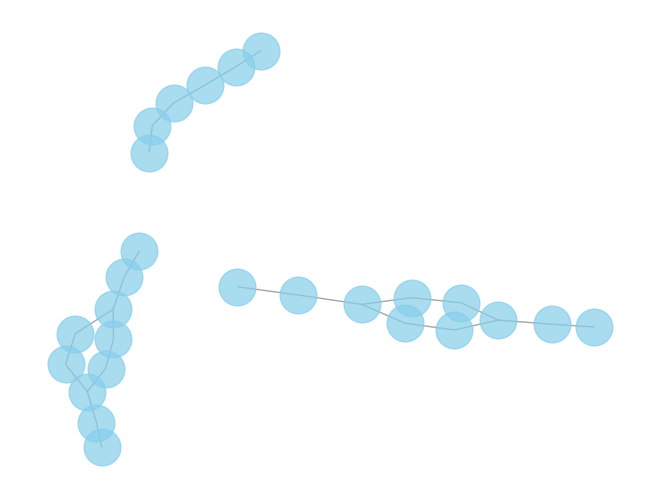

In [74]:
tmp = nx.Graph()
tmp.add_nodes_from(node_ids)
tmp.add_edges_from(neighbors)
pos = nx.spring_layout(tmp)
nx.draw(tmp, pos, with_labels=False, node_size=700, node_color='skyblue', font_size=10, font_color='black', font_weight='bold', edge_color='gray', linewidths=1, alpha=0.7)


# Unmerge #

In [184]:
def unmerge(nodes, source_to_target, target_to_source):
    queue = collections.deque()
    dag_id = 0
    visited = set()
    for node_id in nodes:
        if node_id not in target_to_source:
            queue.append((node_id, dag_id))
            dag_id += 1
    unmerged_nodes = [[] for i in range(dag_id)]
    unmerged_edges = [[] for i in range(dag_id)]
    while queue:
        nid, did = queue.popleft()
        visited.add(nid)
        unmerged_nodes[did].append(nid)
        for neighbor in source_to_target[nid]:
            if neighbor not in visited:
                queue.append((neighbor, did))
            if (nid, neighbor) not in unmerged_edges[did]:
                unmerged_edges[did].append((nid, neighbor))
    return unmerged_nodes, unmerged_edges

In [185]:
unmerged_nodes, unmerged_edges = unmerge(node_ids, source_to_target, target_to_source)

In [177]:
nodes_to_did = {}
for i in range(len(unmerged_nodes)):
    for n in unmerged_nodes[i]:
        nodes_to_did[n] = i

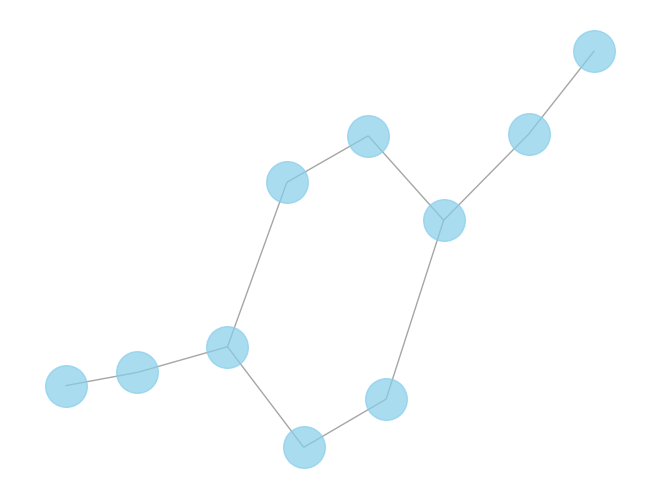

In [117]:
for i in range(0,len(unmerged_nodes)):
    tmp = nx.Graph()
    tmp.add_nodes_from(unmerged_nodes[i])
    tmp.add_edges_from(unmerged_edges[i])
    pos = nx.spring_layout(tmp)
    nx.draw(tmp, pos, with_labels=False, node_size=900, node_color='skyblue', font_size=10, font_color='black', font_weight='bold', edge_color='gray', linewidths=1, alpha=0.7)
    break

# Project #

In [214]:
def project_r(N, d, nodes, edges):
    start_predicate = convert_jsonpath(N)
    query = "MATCH path=(n)-[*..{}]->(m) WHERE ".format(d)
    i = 0
    while i < len(start_predicate):
        if i != len(start_predicate)-2:
            query += "n.{} =~ '{}' AND ".format(start_predicate[i].split('\n')[0], start_predicate[i+1].split('\n')[0])
        else:
            query += "n.{} =~ '{}'".format(start_predicate[i].split('\n')[0], start_predicate[i+1].split('\n')[0])
        i += 2
    query += '''
    RETURN nodes(path) as nodes, relationships(path) as edges
    '''
    result = memgraph.execute_and_fetch(query)
    node_set = set()
    proj_nodes = []
    edge_set = set()
    proj_edges = []
    merge(result, node_set, proj_nodes, edge_set, proj_edges)
    proj_res = collections.defaultdict(list)
    for [proj_source, proj_target, label] in proj_edges:
        proj_res[nodes_to_did[proj_source]].append((proj_source, proj_target))
    return proj_res

def project_p(N, p, nodes, edges):
    start_predicate = convert_jsonpath(N)
    query = "MATCH path={} WHERE ".format(p)
    i = 0
    while i < len(start_predicate):
        if i != len(start_predicate)-2:
            query += "n.{} =~ '{}' AND ".format(start_predicate[i].split('\n')[0], start_predicate[i+1].split('\n')[0])
        else:
            query += "n.{} =~ '{}'".format(start_predicate[i].split('\n')[0], start_predicate[i+1].split('\n')[0])
        i += 2
    query += '''
    RETURN nodes(path) as nodes, relationships(path) as edges
    '''
    result = memgraph.execute_and_fetch(query)
    node_set = set()
    proj_nodes = []
    edge_set = set()
    proj_edges = []
    merge(result, node_set, proj_nodes, edge_set, proj_edges)
    proj_res = collections.defaultdict(list)
    for [proj_source, proj_target, label] in proj_edges:
        proj_res[nodes_to_did[proj_source]].append((proj_source, proj_target))
    return proj_res
    
def project_b(N, d, nodes, edges):
    start_predicate = convert_jsonpath(N)
    query = "MATCH path=(n)<-[*..{}]-(m) WHERE ".format(d)
    i = 0
    while i < len(start_predicate):
        if i != len(start_predicate)-2:
            query += "n.{} =~ '{}' AND ".format(start_predicate[i].split('\n')[0], start_predicate[i+1].split('\n')[0])
        else:
            query += "n.{} =~ '{}'".format(start_predicate[i].split('\n')[0], start_predicate[i+1].split('\n')[0])
        i += 2
    query += '''
    RETURN nodes(path) as nodes, relationships(path) as edges
    '''
    result = memgraph.execute_and_fetch(query)
    node_set = set()
    proj_nodes = []
    edge_set = set()
    proj_edges = []
    merge(result, node_set, proj_nodes, edge_set, proj_edges)
    proj_res = collections.defaultdict(list)
    for [proj_source, proj_target, label] in proj_edges:
        proj_res[nodes_to_did[proj_source]].append((proj_source, proj_target))
    return proj_res

In [196]:
project_res_r = project_r("['type'='material_run']", 1, unmerged_nodes, unmerged_edges)

In [206]:
project_res_p = project_p("['type'='material_run']", "(n:material_run)-[r]->(m:ingredient_run)", unmerged_nodes, unmerged_edges)


In [215]:
project_res_b = project_b("['type'='material_run']", 1, unmerged_nodes, unmerged_edges)

# Deduplicate #

In [ ]:
if value.type = nominal_real apply f1, else if value.type = uniform_real apply f2, else default, agg=sum, tau=0.1

In [1]:
def query_processing(query):
    l = query.split(',')
    tmps = []
    conditions = []
    for i in range(len(conditions)):
        if i == 0:
            tmp = conditions[i].split('if')
        elif i == len(conditions)-1:
            tmp = conditions[i].split('else')
        else:
            tmp = conditions[i].split('else if')
        tmps.append(tmp)
    for tmp in tmps:
        first = tmp.split('=')[0]
        second = tmp.split('=')[1].split('apply')[0]
        third = tmp.split('=')[1].split('apply')[1]
        conditions.append((first, second, third))
    

In [ ]:
def dedup():
    